`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 

В практических примерах ниже показано:   

* как снижать размерность пространства признаков методом частных наименьших квадратов (PLS)
* как строить логистическую регрессию с регуляризацией параметров (метод лассо) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 
*Данные*: `winequality-white_for_lab` (источник: https://github.com/aksyuk/MTML/blob/main/Labs/data/winequality-white_for_lab.csv)

## Загружаем пакеты

In [104]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns


# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [105]:
# константы
#  ядро для генератора случайных чисел
my_seed = 8
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [106]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Набор данных `winequality-white_for_lab`. Данные по качеству 4898 белых вин. Задача: спрогнозировать высокое / низкое качество вина. Источник данных: статья P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.. Набор данных был загружен из репозитория UCI (https://archive.ics.uci.edu/ml/datasets/wine+quality) 12.10.2021. Большинство столбцов таблицы отражают содержание в вине различных веществ:   

* `fixed_acidity`– постоянная кислотность; 
* `volatile_acidity`– переменная кислотность;
* `citric_acid`– содержание лимонной кислоты;
* `chlorides`– содержание хлоридов;
* `total_sulfur_dioxide`– общее содержание диоксида серы;
* `density`– плотность;
* `pH`– кислотность;
* `sulphates`– содержание сульфатов;
* `alcohol`– содержание алкоголя;
* `Y`– целевая переменная: 1 = высокое качество (quality > 5), 0 = низкое (quality <= 5).

Загружаем данные во фрейм и выясняем их размерность.  

In [107]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-white_for_lab.csv'
DF_all = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (4898, 13)


In [108]:
DF_all = DF_all.drop(["residual_sugar", "free_sulfur_dioxide", "quality"], axis = 1)

In [109]:
DF_all.head(10)

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
0,7.0,0.27,0.36,0.045,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,0.049,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,0.050,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,0.058,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,0.058,186.0,0.9956,3.19,0.40,9.9,1
5,8.1,0.28,0.40,0.050,97.0,0.9951,3.26,0.44,10.1,1
6,6.2,0.32,0.16,0.045,136.0,0.9949,3.18,0.47,9.6,1
7,7.0,0.27,0.36,0.045,170.0,1.0010,3.00,0.45,8.8,1
8,6.3,0.30,0.34,0.049,132.0,0.9940,3.30,0.49,9.5,1
9,8.1,0.22,0.43,0.044,129.0,0.9938,3.22,0.45,11.0,1


Отложим 15% наблюдений для прогноза.  

In [110]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [111]:
# первые 5 строк фрейма
DF.head(5)

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
4245,7.6,0.35,0.47,0.037,116.0,0.99822,3.04,0.50,9.2,0
945,6.7,0.15,0.29,0.058,105.0,0.99460,3.52,0.44,10.2,1
394,6.8,0.37,0.51,0.044,163.0,0.99760,3.19,0.44,8.8,0
3464,6.9,0.29,0.41,0.046,171.0,0.99537,3.12,0.51,9.6,0
4261,6.0,0.31,0.27,0.042,120.0,0.98952,3.32,0.41,12.7,1


In [112]:
# типы столбцов фрейма
DF.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
chlorides               float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [113]:
# считаем пропуски в каждом столбце
DF.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
chlorides               0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [114]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [115]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

1    0.664
0    0.336
Name: Y, dtype: float64

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [116]:
# описательные статистики
DF.iloc[:, :9].describe()

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,6.853147,0.278675,0.333666,0.046029,138.093682,0.994018,3.187821,0.489181,10.519741
std,0.839406,0.101242,0.121310,0.022604,42.015077,0.003026,0.150405,0.114023,1.237346
min,3.800000,0.080000,0.000000,0.009000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,0.036000,108.000000,0.991700,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,0.043000,134.000000,0.993700,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,0.050000,167.000000,0.996135,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,0.346000,344.000000,1.038980,3.800000,1.080000,14.200000


Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 9 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

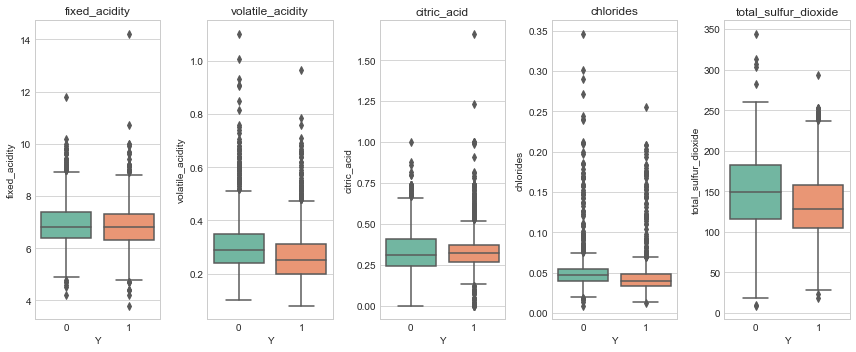

In [117]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
    
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

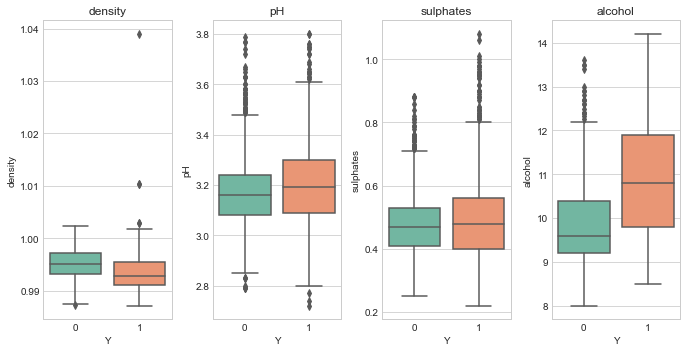

In [118]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

axs = [ax1, ax2, ax3, ax4]

cols_loop = list(DF.columns[5:9].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
    
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках небольшое отличие в медианах и разбросе между классами прослеживается практически по всем объясняющим переменным. Больше всего различаются коробчатые диаграммы по переменной `alcohol`. Меньше всего различаются коробчатые диаграммы по переменным `fixed_acidity` и `chlorides`. Это говорит о том, классы по зависимой переменной `Y` неплохо разделяются по всем объясняющим переменным.

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

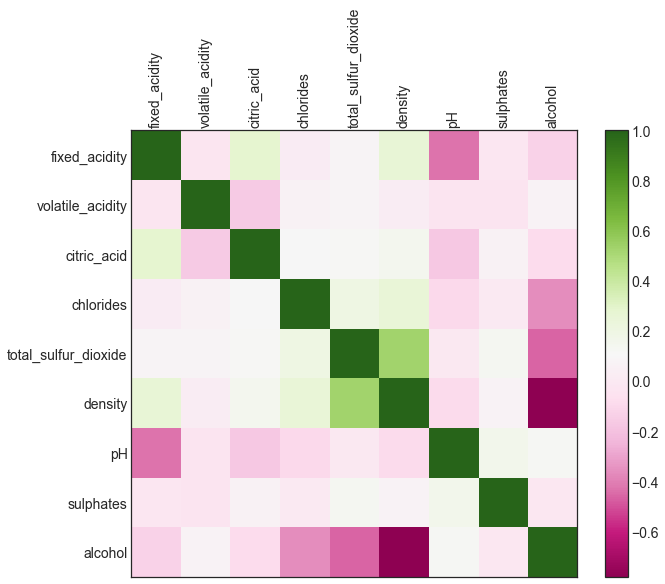

In [119]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [120]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
32,density,alcohol,-0.779497,0.0
29,total_sulfur_dioxide,alcohol,-0.458623,0.0
5,fixed_acidity,pH,-0.425540,0.0
25,chlorides,alcohol,-0.359460,0.0
18,citric_acid,pH,-0.167299,0.0
8,volatile_acidity,citric_acid,-0.160414,0.0
7,fixed_acidity,alcohol,-0.125214,0.0
23,chlorides,pH,-0.096282,0.0
30,density,pH,-0.090565,0.0
20,citric_acid,alcohol,-0.079872,0.0


# Методы снижения резмерности  

Посмотрим, как работает частный метод наименьших квадратов (PLS)  

Метод требует предварительной стандартизации переменных.

In [121]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :9].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = 0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = 0.0   Станд. отклонение = 1.0
Столбец 3: среднее = -0.0   Станд. отклонение = 1.0
Столбец 4: среднее = -0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = -0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0


## Метод частных наименьших квадратов (PLS) 

Сначала посмотрим, как работает метод на всех наблюдениях обучающего набора.  

In [122]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=9)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF[['Y']].astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.24  0.107 0.047 0.079 0.073 0.088 0.071 0.098 0.081] 
Общая сумма долей: 0.884


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$, компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [123]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.560480,0.439520
1,0.247238,0.752762
2,0.621386,0.378614
3,0.439417,0.560583
4,0.116224,0.883776
...,...,...
4158,0.593910,0.406090
4159,0.819364,0.180636
4160,0.409330,0.590670
4161,0.431658,0.568342


In [124]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 905), (1, 3258)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

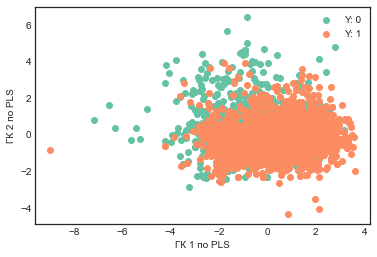

In [125]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0], 
            X_train_pls[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0], 
            X_train_pls[DF['Y'] == 1][:, 1], label='Y: 1')

plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Видно, что в координатах двух компонент, рассчитанных методом частных наименьших квадратов, классы оказываются средне разделимы.  
Теперь оценим точность модели с перекрёстной проверкой.  

In [126]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
score = list()
score_models = list()
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)

score.append(np.around(np.mean(acc_blocks), 3))
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.73


# Методы сжатия   

## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [127]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [0.897] 
Коэффициенты моделей для классов:
 [[-0.248 -0.67   0.007 -0.021  0.05   0.455 -0.083  0.121  1.475]]


In [128]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed+3,
                               penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
lasso_cv.C_

array([0.35938137])

In [129]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 0.75


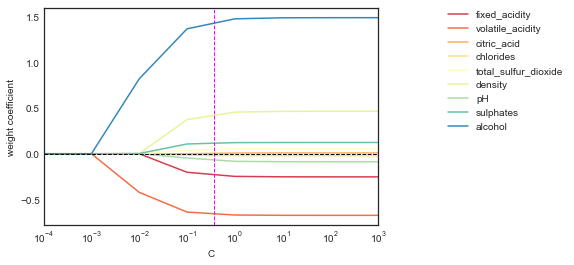

In [130]:
# график динамики коэффициентов в лассо-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, DF.columns)

Итак, судя по графику, для значения гиперпараметра, дающего самую точную модель, ни один из коэффициентов при объясняющих переменных не обнуляется. Это подтверждает наблюдение, сделанное нами ещё на этапе предварительного анализа: все объясняющие переменные неплохо разделяют классы.


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [131]:
# сводка по точности моделей
pd.DataFrame({'Модель' : (score_models[0], score_models[1]), 'Acc' : (score[0], score[1])})

,Модель,Acc
0,logit_PLS,0.728
1,logit_lasso,0.750


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается лассо-регрессия. Сделаем прогноз на отложенные наблюдения.  

In [132]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :9].values)
Y_pred = DF_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.70      0.52      0.60       243
           1       0.79      0.89      0.84       492

    accuracy                           0.77       735
   macro avg       0.75      0.71      0.72       735
weighted avg       0.76      0.77      0.76       735



Итак, методом логистической регрессии со сжатием коэффициенты с L1-регуляризацией мы получили идеально точную модель классификации двух видов белых вин.  